# Making maps
![all the suburbs in sydney](all_burbs.png)

We're going to get some shapefiles from data.gov.au, and then we're going to draw some maps

You'll need some prequisite libraries:
```
pip install pandas shapely fiona descartes pyproj geopandas
```
You may have some already but pip will be cool with that

We're going to get a shapefile of suburb boundaries from here:

https://data.gov.au/dataset/ds-dga-91e70237-d9d1-4719-a82f-e71b811154c6/details

In [20]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

shp_file_name = "NSW_LOCALITY_POLYGON_shp/NSW_LOCALITY_POLYGON_shp.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = ("https://data.gov.au/dataset/91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
                 "5e295412-357c-49a2-98d5-6caf099c2339/download/nsw_locality_polygon_shp.zip")

In [21]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

To get a load of shape files from data.gov.au, more specifically, [here](https://data.gov.au/dataset/nsw-suburb-locality-boundaries-psma-administrative-boundaries/resource/bf8b5180-fcea-44bd-bd76-af14cc4b0fe0)

In [22]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [23]:
# Get the data loaded. This is a bit complicated because it's online as a zip file.
# If we don't have it right now, we need to get it and unzip it.
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


#### Shapefiles are the format that a lot of GIS tools use.

#### GIS means Geographic Information System

pronounced: _gee eye ess_

not pronounced: _jizz_

In [24]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.drop(["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4", "DT_RETIRE"], axis=1, inplace=True)
burbs.head(2)

,LC_PLY_PID,DT_CREATE,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_5,NSW_LOCA_6,NSW_LOCA_7,geometry
0,25065,2015-09-03,NSW2557,2015-11-10,MAYFIELD WEST,G,None,1,"POLYGON ((151.73344571654 -32.87974104891, 151..."
1,16193,2011-11-22,NSW4136,2012-02-04,WALLACETOWN,G,None,1,"POLYGON ((147.450924738497 -34.9651865379095, ..."


In [25]:
#  burbs.geometry.plot()
#  could plot, if you had a really fast computer!

LC_PLY_PID                                                25065
DT_CREATE                                            2015-09-03
LOC_PID                                                 NSW2557
NSW_LOCALI                                           2015-11-10
NSW_LOCA_2                                        MAYFIELD WEST
NSW_LOCA_5                                                    G
NSW_LOCA_6                                                 None
NSW_LOCA_7                                                    1
geometry      POLYGON ((151.73344571654 -32.87974104891, 151...
Name: 0, dtype: object


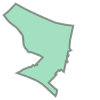

In [27]:
a = burbs.iloc[0]
print(a)
a.geometry

In [28]:
def add_centroid(row):
    return row.geometry.centroid

burbs["centroid"] = burbs.apply(add_centroid, axis=1)

POINT (151.7246099649729 -32.88497041458911)


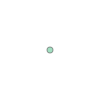

In [30]:
a = burbs.iloc[0]
print(a.centroid)
a.centroid

In [31]:
right_here = shapely.geometry.point.Point(151.2299732, -33.9178754)
burbs["distance_from_UNSW"] = burbs.geometry.distance(right_here)

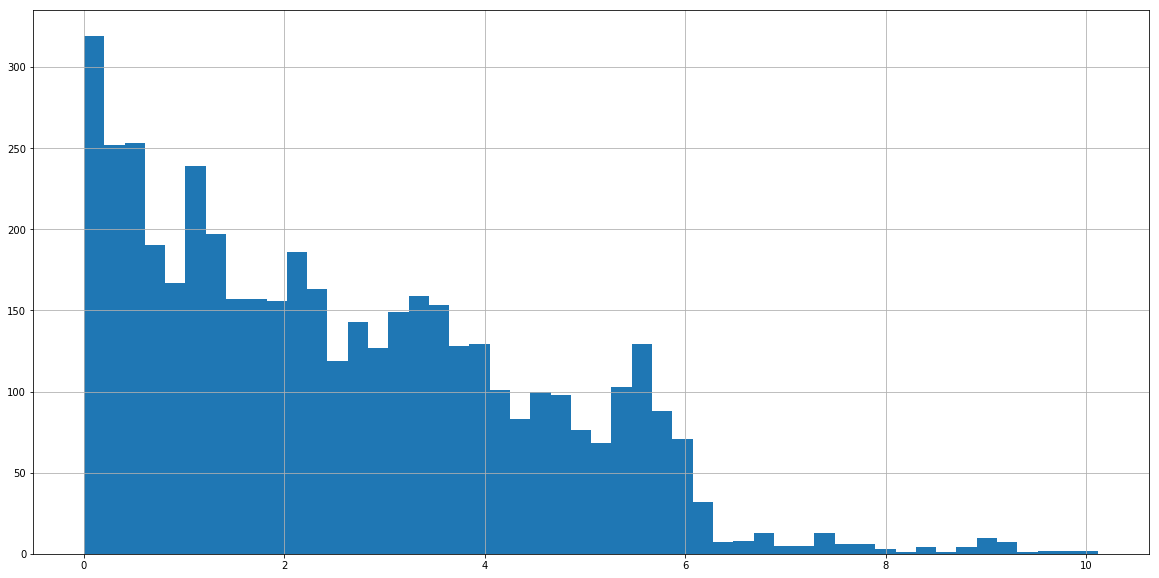

In [32]:
burbs.distance_from_UNSW.hist(bins=50);

This gives distance in whole numbers of lat long I think, i.e. degrees!

Not really sure what to do with that, but let's get rid of everything above 0.2 and see what we can plot:

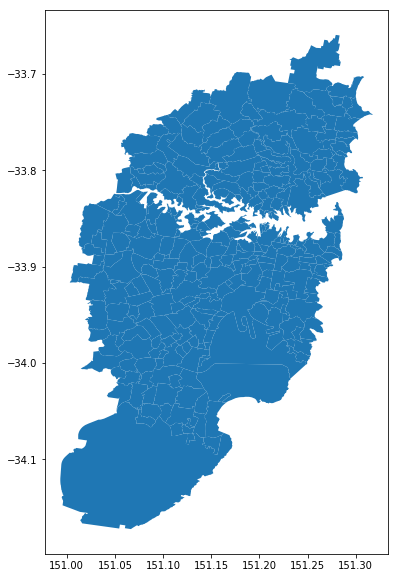

In [45]:
close_burbs = burbs[burbs.distance_from_UNSW<0.2]
close_burbs.plot();

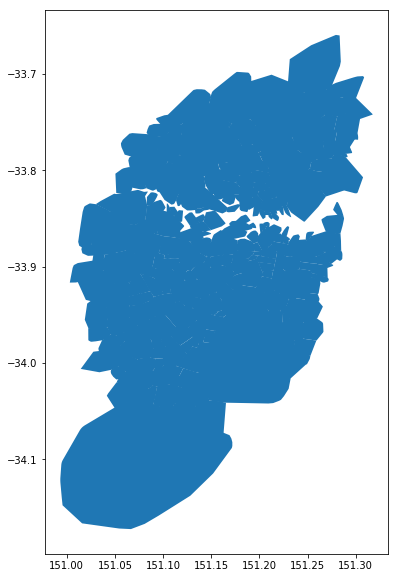

In [34]:
close_burbs.geometry.convex_hull.plot();

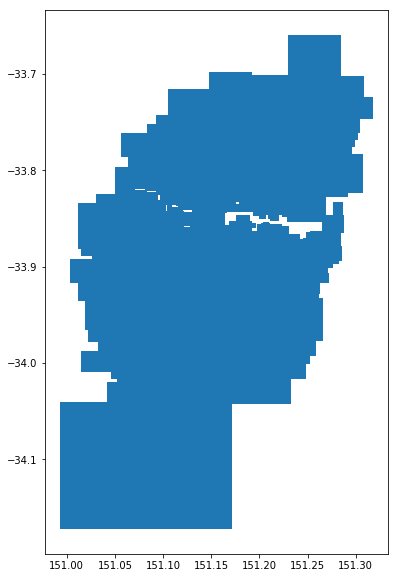

In [35]:
close_burbs.geometry.envelope.plot();

![](http://www.personal.kent.edu/~rmuhamma/Compgeometry/MyCG/Gifs-CompGeometry/ch2.gif)
Convex hulls are a useful aproximation if you want to do fast calculations.

Bounding boxes are even cheaper.

What about putting labels on the map?

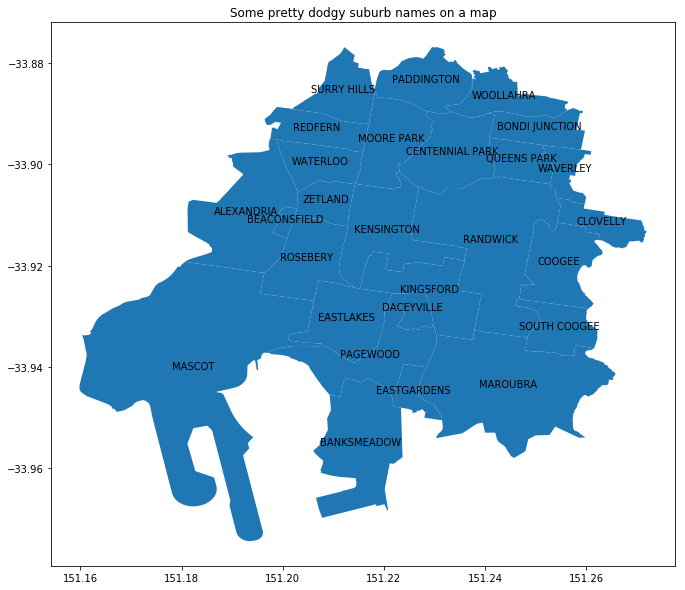

In [36]:
really_close_burbs = burbs[burbs.distance_from_UNSW<0.03]
really_close_burbs.plot()

for idx, row in really_close_burbs.iterrows():
    plt.annotate(text=row.NSW_LOCA_2, 
                 xy=tuple(row.centroid.coords)[0],
                 horizontalalignment='center')
plt.title("Some pretty dodgy suburb names on a map");

We often want to be able to tell if a point is in a suburb or not. We'd do that with a polygon inclusion test.

![](http://www.geeksforgeeks.org/wp-content/uploads/polygon31.png)
[How to check if a given point lies inside or outside a polygon?](http://www.geeksforgeeks.org/how-to-check-if-a-given-point-lies-inside-a-polygon/)

Luckily we've got one built in!

In [38]:
print(right_here)
in_this_burb = None
for _, row in really_close_burbs.iterrows():
    if right_here.within(row.geometry):
        in_this_burb = row
        
in_this_burb

POINT (151.2299732 -33.9178754)


LC_PLY_PID                                                        16612
DT_CREATE                                                    2012-02-16
LOC_PID                                                         NSW2123
NSW_LOCALI                                                   2012-05-04
NSW_LOCA_2                                                   KENSINGTON
NSW_LOCA_5                                                            G
NSW_LOCA_6                                                         None
NSW_LOCA_7                                                            1
geometry              POLYGON ((151.226736204561 -33.904512307867, 1...
centroid                   POINT (151.2206407346472 -33.91336830521539)
distance_from_UNSW                                                    0
Name: 1312, dtype: object

This might actually be a case where a `lambda` is a good idea:

In [46]:
in_this_burb = really_close_burbs[really_close_burbs.apply(lambda x: right_here.within(x.geometry) , axis=1)]
in_this_burb

,LC_PLY_PID,DT_CREATE,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_5,NSW_LOCA_6,NSW_LOCA_7,geometry,centroid,distance_from_UNSW
1312,16612,2012-02-16,NSW2123,2012-05-04,KENSINGTON,G,None,1,"POLYGON ((151.226736204561 -33.904512307867, 1...",POINT (151.2206407346472 -33.91336830521539),0.0


How about colouring suburbs according to some kind of scalar value?

[That's called a _chloropleth_](http://geopandas.readthedocs.io/en/latest/mapping.html?highlight=color#chloropleth-maps)

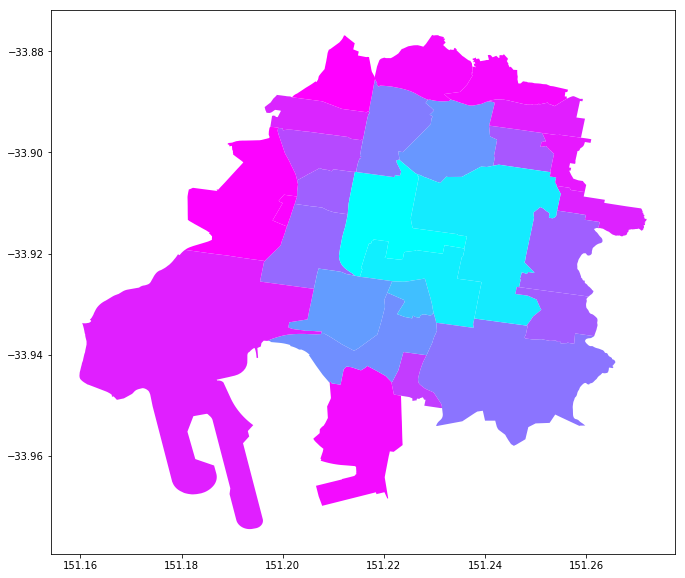

In [49]:
really_close_burbs.plot(column='distance_from_UNSW', cmap='cool');

I don't think that could be any easier!

You can see the list of [colour scale options here](http://matplotlib.org/users/colormaps.html)

## Handy links

* [Geopandas docs](http://geopandas.readthedocs.io)
* [Geopandas on GitHib](https://github.com/geopandas/geopandas)
* [Another map making tutorial](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html)
* [MatPlotLib colour scale options](http://matplotlib.org/users/colormaps.html)

I'd love to hear if you come across any other useful things!